#### Introduction
The goal of this section is to train a convolutional neural network on custom images from scratch. To achieve this, there are few operations we need to perform, which includes:
- Connecting google colab to our google drive
- Data Preparation: creating training and test data from the raw data
- Building the CNN architecture
- Training the network

note that in real-world, dataset will be given to you in form of images and not an encoded numpy format i.e. a numpy excel file carrying the name of the image. this latter has images arranged in order and it is very easy to work with

- Dataset: https://www.kaggle.com/datasets/drgfreeman/rockpaperscissors?resource=download


#### Connect Google Colab to Google Drive


In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


#### import required packages

In [34]:
import cv2
import numpy as np
import os
import random
import shutil
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense


### Data Augmentation
to resize the image. If you want to build cnn from the scratch you need a large dataset. This is whee transfer learning comes in. 2000 images for example is small ; so we create variants of it by rotating it horizontanly, vertically, zooming it, etc. it also make the model invariant to different types of images

#### Prepare training and testing images

In [7]:
# creating empty directories to store the images
# create the train and test directories 
def create_directory (train, test, category): 
# create the train and test directories
  if not os.path.exists(train): 
    os.makedirs (train)
  if not os.path.exists(test): 
    os.makedirs(test)
#create the directories for the 3 categories - rock, scissors and paper
  if not os.path.exists(os.path.join(train, category)): 
    os.makedirs (os.path.join(train, category)) 
  if not os.path.exists(os.path.join(test, category)): 
    os.makedirs(os.path.join(test, category))

In [8]:
path= "/content/drive/MyDrive/PRS"
# there are 3 folders in the path
# checking to confirm the three categories in the path
os.listdir(path)

['rock', 'paper', 'scissors']

the dataset contain custom images i.e. rock, paper and scissors images grouped into their respective folders. For custom images, the train and test dataset for each image type will be generated by creating the training and test directories for the specific category 

In [ ]:
y 

#### Generate train and testing datasets

In [9]:
# code to generate train and test folders for each image type
# create the train and test images 
def get_image(input_dir, category):
  # image directory
  img_dir = os.path.join(input_dir, category)
  
  # define the percentage of images to use for testing 
  test_percent= 0.1
  
  # get the list of all images files in directory 
  image_files = [os.path.join(img_dir, f) for f in os.listdir(img_dir) if
                   os.path.isfile(os.path.join(img_dir, f)) and f.endswith(".png")]  
  
  #shuffle the images; so as not to be bias
  random.shuffle(image_files)
 
  #calculate the number of images to use for training and testing
  num_images = len(image_files)
  num_test = int(test_percent * num_images)
  num_train = num_images - num_test

  #create paths to training and test images 
  train_dir = os.path.join(input_dir, "train") 
  test_dir= os.path.join(input_dir, "test")

  #create the actual training and testing directories 
  create_directory(train_dir, test_dir, category)

  # copy the images to the training and testing directories
  for i in range(num_images):
    img_file = image_files[i]
    if i < num_train:
      #copy the image to the training directory
      shutil.copy(img_file, os.path.join(train_dir, category)) # copy into the right folders
    else:
      # copy image to test directory 
      shutil.copy(img_file, os.path.join(test_dir, category))

In [10]:
categories = ["rock", "paper", "scissors"]
for category in categories: 
  get_image(path, category)

In [11]:
### sanity check for image numbers
dir = "/content/drive/MyDrive/PRS/"
for i in os.listdir(dir):
  print(len(os.listdir(os.path.join(dir, i))))

739
712
750
3
3


- there are 739 images in the paper directory
- there are 712 images in the rock directory
- there are 750 images in the scissor directory
- the other 3 are list of folders

In [12]:
train_dir = "/content/drive/MyDrive/PRS/train"
for i in os.listdir(train_dir):
  print(len(os.listdir(os.path.join(train_dir, i))))

666
641
675


there are 666, 641 and 675 train images in the paper, rock and scissors folders respectively

In [13]:
test_dir = "/content/drive/MyDrive/PRS/test"
for i in os.listdir(test_dir):
  print(len(os.listdir(os.path.join(test_dir, i))))

73
71
75


there are 73, 71 and 75 test images in the paper, rock and scissors folders respectively. they image numbers were converted to integar, otherwise, there will be decimal division

### Dimensionality
if all images are 200 by 200, then all images must be 200 by 200

In [14]:
### sanity check for image sizes
# check the size of the images 
def checkImageSize(dir, category):
  cat_path= os.path.join(dir, category) 
  imgs = os.listdir(cat_path)
  for i in range(5): # checking the size of just 5 of them
    img = imgs[i]
    image =  cv2.imread(os.path.join(cat_path, img)) 
    print(image.shape)



In [15]:
# paper size
checkImageSize(test_dir, "paper")

(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)


In [16]:
# rock size
checkImageSize(test_dir, "rock")

(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)


In [17]:
# scissors size
checkImageSize(test_dir, "scissors")

(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)
(200, 300, 3)


## Model Building

### Data Augmentation
techniques to combat overffiting; it includes normalization/ rescaling, flipping, zooming
- to create many and robust model
- the more the aumentation, the slower the model since your are creating extra work
- you dont augment test data; should only be normalized

In [18]:
# define parameters for data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip =  True,
                                   shear_range= 0.2,
                                   zoom_range= 0.2,
                                   vertical_flip = True)
test_datagen = ImageDataGenerator(rescale =1./255) 
num_classes =  3
es =  EarlyStopping(monitor ="val_loss", patience =  3, verbose =2, mode= "min")

#### Model Architecture

In [19]:
model = Sequential()
model.add(layers.Conv2D(32, (3,3), activation ="relu", input_shape= (200, 300, 3)))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation ="relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation= "relu"))
model.add(layers.MaxPool2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = "relu"))
model.add(layers.Dropout (0.5))
model.add(layers.Dense(num_classes, activation= "softmax"))

# Check the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 298, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 99, 149, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 147, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 73, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 46, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 23, 35, 128)      0

In [20]:
# compile the network
model.compile(optimizer ="adam",
              loss = "categorical_crossentropy",
              metrics= ["accuracy"])

In [21]:
# create the training and test batch of images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size= (200, 300),
                                                    batch_size=32,
                                                    class_mode ="categorical")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size= (200, 300),
                                                  batch_size =32,
                                                  class_mode= "categorical")

Found 1982 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


In [22]:
# train the network
history = model.fit(train_generator, steps_per_epoch = train_generator.samples // 32,
                    validation_steps= test_generator.samples // 32, 
                    validation_data = test_generator, 
                    epochs = 10, callbacks = [es])

Epoch 1/10
61/61 [==============================] - 49s 587ms/step - loss: 1.1134 - accuracy: 0.4667 - val_loss: 0.7290 - val_accuracy: 0.7708
Epoch 2/10
61/61 [==============================] - 34s 556ms/step - loss: 0.6729 - accuracy: 0.7292 - val_loss: 0.3998 - val_accuracy: 0.8802
Epoch 3/10
61/61 [==============================] - 35s 578ms/step - loss: 0.3831 - accuracy: 0.8595 - val_loss: 0.3782 - val_accuracy: 0.8490
Epoch 4/10
61/61 [==============================] - 35s 572ms/step - loss: 0.2848 - accuracy: 0.9010 - val_loss: 0.2095 - val_accuracy: 0.9115
Epoch 5/10
61/61 [==============================] - 33s 544ms/step - loss: 0.2111 - accuracy: 0.9272 - val_loss: 0.1029 - val_accuracy: 0.9792
Epoch 6/10
61/61 [==============================] - 35s 581ms/step - loss: 0.1511 - accuracy: 0.9518 - val_loss: 0.0653 - val_accuracy: 0.9740
Epoch 7/10
61/61 [==============================] - 34s 552ms/step - loss: 0.1644 - accuracy: 0.9421 - val_loss: 0.0949 - val_accuracy: 0.9635

### Visualize the result

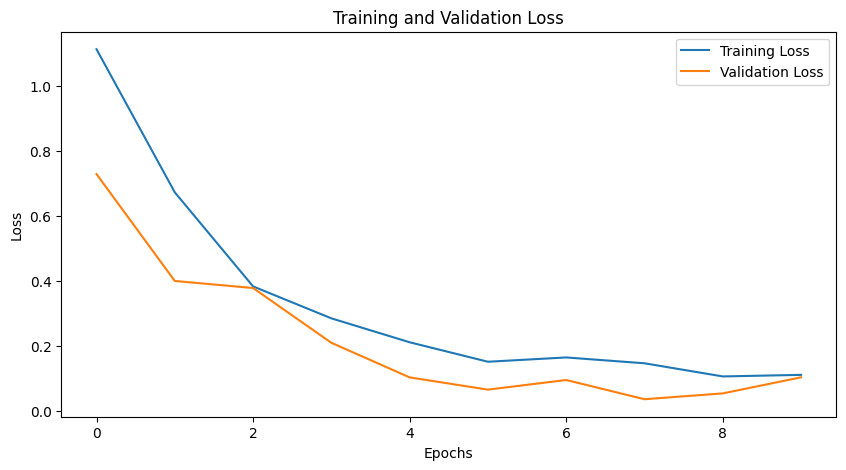

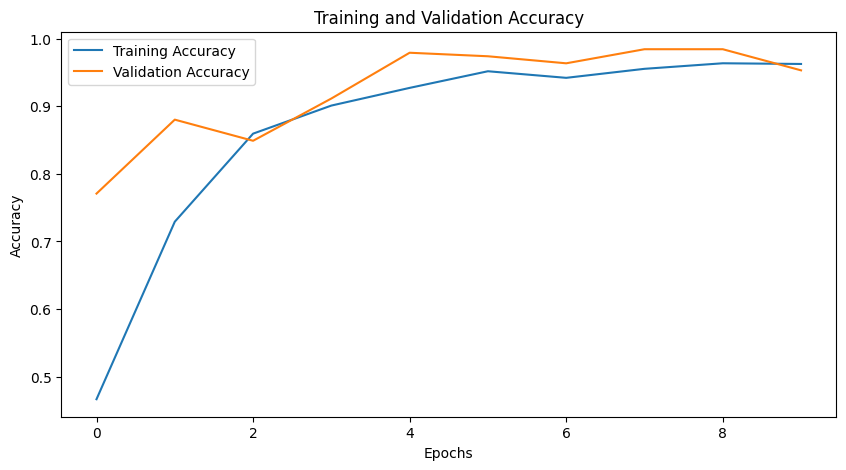

In [24]:
import matplotlib.pyplot as plt

def plot_training_results(history):
    # Plot training and validation loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Visualize the training results
plot_training_results(history)


### Transfer Learning - Applying Pre-trained model on Custom Images

it involves the use of a giant model that has been trained on millions of images in such a way that it is possible to derive some weights from it and use those weight to initialize our model. the aim is to use the convolutional layers in those model to extract the features of our datasets

- Here, we use a pretrained model like VGG16 instead of building our own CNN network from scratch. 
- The advantage is that we get to use the pretrained weights of this model that has been trained on millions of images in the ImageNet dataset.
- Allows training for a shorter time; using few epochs

#### Examples
- VGG16 : This is the simplest of them. It means 16 convolutional blocks
- VGG19
- RESNET50
- RESNET101
- Exception
- inception

#### import necessary libraries

In [41]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras import models, layers

image_size = (200, 300)
batch_size = 32

# Define the generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Create the training and test batch of images
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(200, 300),
                                                    batch_size=32,
                                                    class_mode="categorical")
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(200, 300),
                                                  batch_size=32,
                                                  class_mode="categorical")

# Define VGG16
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(200, 300, 3))
# the VGG16 model was pretrained on a datset called imagenet
# imagenet has about 2 milliion images with 1000 classes

# Freeze the layers, preventing them from training again
for layer in base_model.layers:
    layer.trainable = False

# Model architecture
model = models.Sequential()
model.add(base_model)
# Above represents the convolutional and maxpooling blocks inherited from VGG16

model.add(layers.Flatten())
model.add(layers.Dense(1024, activation="relu"))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(num_classes, activation="softmax"))

# Check the model summary
model.summary()

# Compile the network
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Train the model
history2 = model.fit(train_generator, epochs=2, validation_data=test_generator)


Found 1982 images belonging to 3 classes.
Found 219 images belonging to 3 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 9, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 27648)             0         
                                                                 
 dense_5 (Dense)             (None, 1024)              28312576  
                                                                 
 dropout_2 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 43,030,339
Trainable params: 28,315,651
Non-trainable params: 14,714,688
________________

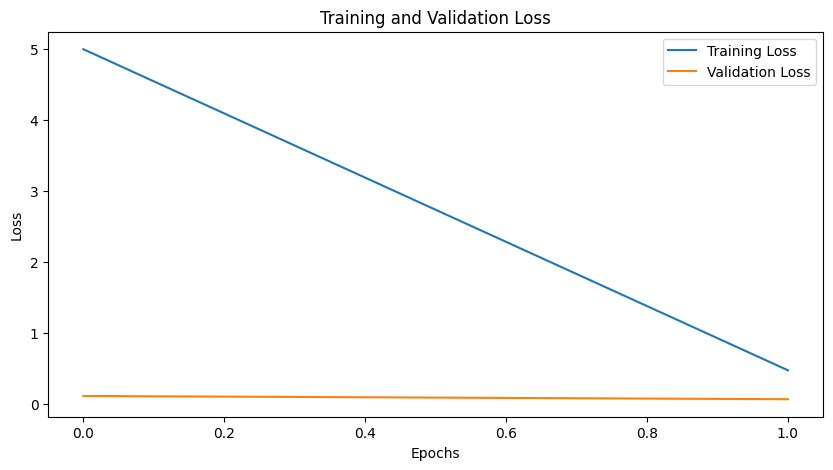

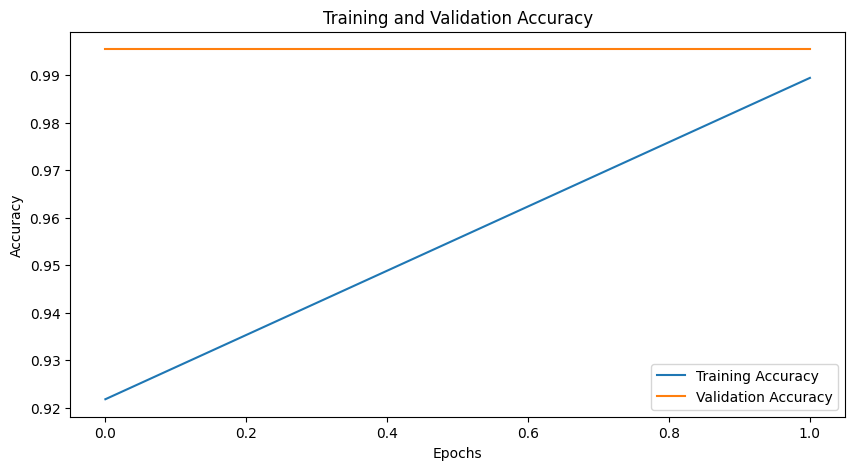

In [44]:
import matplotlib.pyplot as plt

def plot_training_results(history2):
    # Plot training and validation loss for two epochs
    plt.figure(figsize=(10, 5))
    plt.plot(history2.history['loss'][:2], label='Training Loss')
    plt.plot(history2.history['val_loss'][:2], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plot training and validation accuracy for two epochs
    plt.figure(figsize=(10, 5))
    plt.plot(history2.history['accuracy'][:2], label='Training Accuracy')
    plt.plot(history2.history['val_accuracy'][:2], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call the function to plot the training results
plot_training_results(history2)

- just 2 epoch gave us a perfect accuracy
- the model is generalizing well and not overfitting since validation result is more thanth training accuracy even though the validation score is 100% accurate
